### Reverse Correlation Audio

The goal of this analysis is to create an audio file (that we can listen to), which contains 'footage' from the speech based on the brain response of the audience. In other words, we will cut together those parts of the speech, that make a particular brain region more active. This approach is sometimes called 'reverse correlation'. 

Because it is easy to get confused about this, let's unpack it a bit more: Normally, we would perform a 'forward analysis'. In such a forward analysis, one would take a content feature of the stimulus (e.g. the audio/RMSE feature) and ask: Which brain region tracks with this? A reverse correlation is different in its goal, and different in its approach: Rather than going from the stimulus to the brain (forward), we now will go from the brain response back to the stimulus. 

Thus, we will zoom in on a particular region and ask first: At which moments is this brain region significantly engaged (or also to opposite: significantly suppressed/lowered)? We will then note the time-points for those segments, such as region1_peak1: 65-68 seconds, region1_peak2: 89-95 seconds, ..... With this time-sheet of 'moments of maximum regional brain activtity', we will then go back to the audio-recording of the speech, cut out the relevant segments, and create a new audio-file - pretty much like a "brain-based trailer of the speech". 

Then, we can listen to this trailer to see if we can identify a particular content element that seems to be present in this trailer.



In [150]:
import re, sys
import nilearn
from nilearn import plotting, input_data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from pieman_utils import *
import seaborn as sns

from scipy.stats import zscore

### load text

In [151]:
pie_text = pd.read_csv('../data_pieman/align.csv',
           header = None, names  = ['text','text2', 'onset_time', 'offset_time'])
pie_text.head()

,text,text2,onset_time,offset_time
0,I,i,15.089999,15.169999
1,began,began,15.170000,15.510000
2,my,my,15.509999,15.699999
3,illustrious,<unk>,15.710000,16.310000
4,career,career,16.330000,16.940000


### load fMRI data

In [152]:
fmri_data = np.load('../data_pieman/fmri_data_pieman.npy')
print(fmri_data.shape)


data = fmri_data.copy()
data = np.swapaxes(data, 0,1)
data = np.swapaxes(data, 1,2)
print(data.shape)

shen_file       = '../data_pieman/shen_2mm_268_parcellation.nii'
shen_masker = nilearn.input_data.NiftiLabelsMasker(labels_img=shen_file);
sample_file = '../data_pieman/func.nii'
shen_masker.fit_transform(sample_file);

(68, 300, 293)
(300, 293, 68)


### plot time courses from auditory cortex, TPJ, and N. accumbens

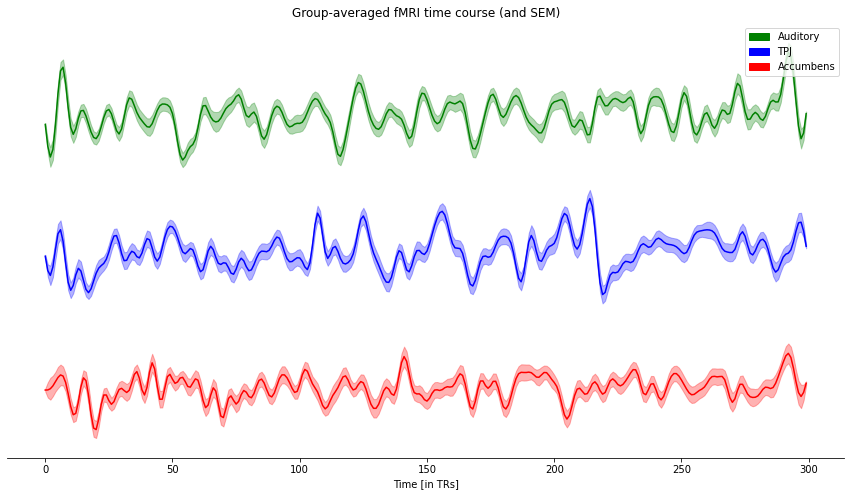

In [193]:

curr_roi = 183
curr_data = data[:,curr_roi,:]
x = np.arange(curr_data.shape[0])
y = np.mean(curr_data, axis =1)
yerr = np.std(curr_data, axis =1)/np.sqrt(curr_data.shape[1])

plt.figure(figsize= (15,8));
#ax1 = plt.axes()

errorfill(x, y, yerr, color='blue');


curr_roi = 61
curr_data = data[:,curr_roi,:]
x = np.arange(curr_data.shape[0])
y = np.mean(curr_data, axis =1) +2
yerr = np.std(curr_data, axis =1)/np.sqrt(curr_data.shape[1])
errorfill(x, y, yerr, color='green');


curr_roi = 270
curr_data = data[:,curr_roi,:]
x = np.arange(curr_data.shape[0])
y = np.mean(curr_data, axis =1) - 2
yerr = np.std(curr_data, axis =1)/np.sqrt(curr_data.shape[1])
errorfill(x, y, yerr, color='red');


plt.title('Group-averaged fMRI time course (and SEM)');
#sns.despine()

plt.yticks([]) 

sns.despine(left=True);



#ax1.axes.get_yaxis().set_visible(False)

#r2 = np.zeros((1,268))
#r2[0, curr_roi] = 1
#res_img = shen_masker.inverse_transform(r2);
#plotting.plot_glass_brain(nilearn.image.index_img(res_img,0), colorbar=False, 
#                         cmap="Reds", threshold=0.15, plot_abs=False,display_mode='x');

#curr_means = np.mean(data[:,[61, 183, 270],:], axis=2)
#plt.imshow(np.corrcoef(curr_means.T), cmap = 'seismic', vmin =-1, vmax = 1);
#plt.colorbar();

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

green_patch = mpatches.Patch(color='green', label='Auditory')
blue_patch = mpatches.Patch(color='blue', label='TPJ')
red_patch = mpatches.Patch(color='red', label='Accumbens')

plt.legend(handles=[green_patch,blue_patch,red_patch], loc = 1)
plt.xlabel('Time [in TRs]')
plt.show()


### Focus on Accumbens first: Where are peaks and troughs?

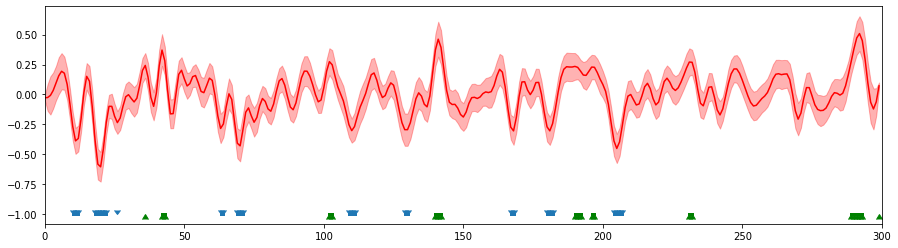

In [256]:
curr_roi = 270
curr_data = data[:,curr_roi,:]
threshold = 2 # this is the stats threshold

# we're doing essentially a point-by-point t-test
x = np.arange(curr_data.shape[0])
y = np.mean(curr_data, axis =1)
yerr = np.std(curr_data, axis =1)/np.sqrt(curr_data.shape[1])

# converting to z-scores (or: t-scores)
z = y/yerr
z2 = z.copy()

# positive and negative thresholding
z[z<threshold] = np.nan
z[z>threshold] = -1

z2[z2>-threshold] = np.nan
z2[z2<threshold]  = -1

# plot
plt.figure(figsize= (15,4));
errorfill(x, y, yerr, color='red');

plt.plot(z, linewidth = 3, marker = 6, color = 'green'); #caretup

plt.plot(z2, linewidth = 3,  marker = 7);
plt.xlim([0,300]);

In [249]:
'''curr_roi = 271
curr_data = data[:,curr_roi,:]
threshold = 1.5 # this is the stats threshold
x = np.arange(curr_data.shape[0])
y = np.mean(curr_data, axis =1)
yerr = np.std(curr_data, axis =1)/np.sqrt(curr_data.shape[1])

# converting to z-scores (or: t-scores)
z = y/yerr
z[z<threshold] = np.nan
z[z>threshold] = -1
plt.figure(figsize= (15,4));
errorfill(x, y, yerr, color='red');
plt.plot(z, linewidth = 3, marker = 6, color = 'green'); #caretup
plt.xlim([0,300]);'''

"curr_roi = 271\ncurr_data = data[:,curr_roi,:]\nthreshold = 1.5 # this is the stats threshold\nx = np.arange(curr_data.shape[0])\ny = np.mean(curr_data, axis =1)\nyerr = np.std(curr_data, axis =1)/np.sqrt(curr_data.shape[1])\n\n# converting to z-scores (or: t-scores)\nz = y/yerr\nz[z<threshold] = np.nan\nz[z>threshold] = -1\nplt.figure(figsize= (15,4));\nerrorfill(x, y, yerr, color='red');\nplt.plot(z, linewidth = 3, marker = 6, color = 'green'); #caretup\nplt.xlim([0,300]);"

Having identified the peaks (and troughs - see green and blue indicators above), we next will start to identify which text corresponds to these peaks? For this, we'll first load the audiofile


### Load the audio file 

In [250]:
from IPython.display import Audio
sound_file = '../data_pieman/pieman.wav'

from scipy.io import wavfile
samplerate, sounddata = wavfile.read(sound_file)
print(data.shape[0]/samplerate)
print(samplerate)

#Audio(sound_file,)

0.0375
8000


### Identify the 'moments' (time segments) during which the fMRI signal maxed:

In [251]:
tr_peaks = np.where(z<0)
print(tr_peaks)

(array([ 35,  36,  41,  42,  43,  49,  53,  54,  93,  94, 101, 102, 103,
       140, 141, 142, 143, 163, 186, 187, 188, 189, 190, 191, 192, 195,
       196, 197, 198, 230, 231, 232, 233, 247, 248, 289, 290, 291, 292,
       293, 294, 299]),)


### Isolating the text that corresponds to these moments

In [252]:
tr_shift = 3
pie_text['tr'] = divmod(pie_text['onset_time'], 1.5)[0] + tr_shift
pie_text

,text,text2,onset_time,offset_time,tr
0,I,i,15.089999,15.169999,14.0
1,began,began,15.170000,15.510000,14.0
2,my,my,15.509999,15.699999,14.0
3,illustrious,<unk>,15.710000,16.310000,14.0
4,career,career,16.330000,16.940000,14.0
...,...,...,...,...,...
952,tell,tell,428.610000,428.800000,289.0
953,me,me,428.799999,428.939999,289.0
954,all,all,428.940000,429.070000,289.0
955,about,about,429.070000,429.270000,290.0


In [253]:
high_res = []

for i in range(len(tr_peaks[0])):
    erg = pie_text[pie_text['tr'] == tr_peaks[0][i]]
    #print(erg)
    high_res.append(erg['text'].values)
    #print('_____')
    
high_res = [item for sublist in high_res for item in sublist]
print(high_res)

['University', 'plans', 'to', 'raise', 'tuition', 'substantially', 'above', 'the', 'inflation', 'and', 'looks', 'at', 'me', 'and', 'he', 'says', 'Listen', 'up', 'punk', 'And', 'next', 'to', 'me', 'And', 'then', 'runs', 'away', 'And', 'they', 'recommend', 'and', 'I', 'kind', 'of', 'liked', 'it', 'So', 'the', 'first', 'I', 'did', 'And', 'that�۪s', 'how', 'the', 'first', 'line', 'got', 'crossed', 'A', 'few', 'days', 'later', 'was', 'different', 'from', 'me', 'drinking', 'on', 'campus', 'The', 'infamous', 'no', 'more', 'beer', 'at', 'barbecues', 'rule', 'That�۪s', 'right', 'boo', 'that', 'rule', 'Sheila', 'thought', 'drinking', 'in', 'public', 'was', 'in', 'think', 'you', 'know', 'what', 'happened', 'next', 'Pie', 'Man', 'emerged', 'from', 'behind', 'the', 'with', 'some', 'friends', 'And', 'now', 'Angela', 'and', 'I', 'had', 'been', 'flirting', 'for', 'two', 'months', 'Or', 'I', 'And', 'it', 'was', 'her', 'And', 'and', 'tell', 'me', 'all', 'about', 'it']


### 'Cutting back' these chunkgs into an audio-file

In [254]:
tr = 1.5
wavonsetseconds = (tr_peaks[0]- tr_shift)*tr
increment = tr*samplerate
wavonsetsamples = wavonsetseconds*samplerate

peakcut = []
for i in range(len(wavonsetsamples)):
    peakcut.extend( sounddata[ int(wavonsetsamples[i]):int((wavonsetsamples[i]+increment)) ] )
    
peakcut = np.asarray(peakcut)
print(peakcut.shape)

(504000,)


In [255]:
from scipy.io.wavfile import write

write('test.wav', samplerate, peakcut)
Audio('test.wav', )

### Do the same for the TPJ

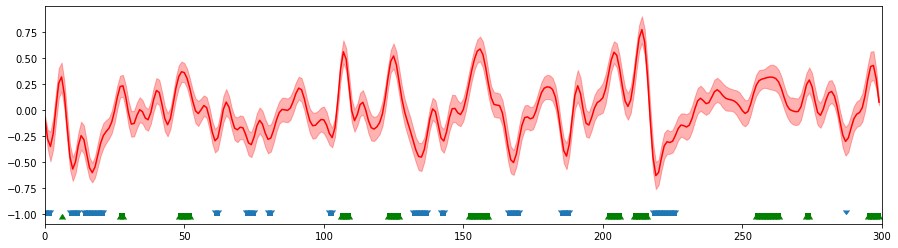

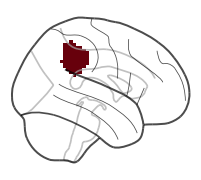

In [258]:
curr_roi = 183
curr_data = data[:,curr_roi,:]
threshold = 2


#
x = np.arange(curr_data.shape[0])
y = np.mean(curr_data, axis =1)
yerr = np.std(curr_data, axis =1)/np.sqrt(curr_data.shape[1])

z = y/yerr
z2 = z.copy()

z[z<threshold] = np.nan
z[z>threshold] = -1

z2[z2>-threshold] = np.nan
z2[z2<threshold]  = -1

plt.figure(figsize= (15,4));
errorfill(x, y, yerr, color='red');

plt.plot(z, linewidth = 3, marker = 6, color = 'green'); #caretup

plt.plot(z2, linewidth = 3,  marker = 7);
plt.xlim([0,300]);

r2 = np.zeros((1,268))
r2[0, curr_roi] = 1
res_img = shen_masker.inverse_transform(r2);

plotting.plot_glass_brain(nilearn.image.index_img(res_img,0), 
                          colorbar=False, 
                          cmap="Reds", 
                          threshold=0.15,
                          plot_abs=False, 
                          display_mode='x');

In [259]:
tr_peaks = np.where(z<0)
print(tr_peaks)


wavonsetseconds = (tr_peaks[0]- tr_shift)*tr
increment = tr*samplerate
wavonsetsamples = wavonsetseconds*samplerate

peakcut = []
for i in range(len(wavonsetsamples)):
    peakcut.extend( sounddata[ int(wavonsetsamples[i]):int((wavonsetsamples[i]+increment)) ] )
    
peakcut = np.asarray(peakcut)
print(peakcut.shape)

from scipy.io.wavfile import write

write('test.wav', samplerate, peakcut)
Audio('test.wav', )


(array([  6,  27,  28,  48,  49,  50,  51,  52, 106, 107, 108, 109, 123,
       124, 125, 126, 127, 152, 153, 154, 155, 156, 157, 158, 159, 202,
       203, 204, 205, 206, 211, 212, 213, 214, 215, 216, 255, 256, 257,
       258, 259, 260, 261, 262, 263, 273, 274, 295, 296, 297, 298, 299]),)
(624000,)


In [ ]:
resmat_all = np.nanmean(data[:,:,:], axis =2)
resmat_all.shape

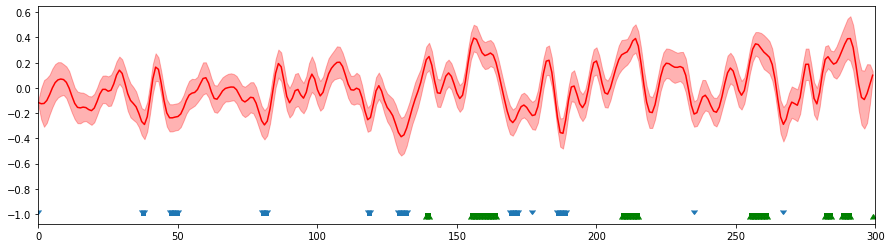

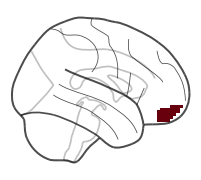

In [230]:
curr_roi = 0
curr_data = data[:,curr_roi,:]
threshold = 2


#
x = np.arange(curr_data.shape[0])
y = np.mean(curr_data, axis =1)
yerr = np.std(curr_data, axis =1)/np.sqrt(curr_data.shape[1])

z = y/yerr
z2 = z.copy()

z[z<threshold] = np.nan
z[z>threshold] = -1

z2[z2>-threshold] = np.nan
z2[z2<threshold]  = -1

plt.figure(figsize= (15,4));
errorfill(x, y, yerr, color='red');

plt.plot(z, linewidth = 3, marker = 6, color = 'green'); #caretup

plt.plot(z2, linewidth = 3,  marker = 7);
plt.xlim([0,300]);

r2 = np.zeros((1,268))
r2[0, curr_roi] = 1
res_img = shen_masker.inverse_transform(r2);

plotting.plot_glass_brain(nilearn.image.index_img(res_img,0), 
                          colorbar=False, 
                          cmap="Reds", 
                          threshold=0.15,
                          plot_abs=False, 
                          display_mode='x');

In [ ]:
plt.plot(pie_text['tr'])

In [ ]:
for i in range(len(pie_text['text'].values)):
    print(pie_text['text'].values[i] + ' ___ ' + str(pie_text['tr'].values[i]))

In [ ]:
'''Intro: 
    Segment 1 :    "i began my .... more prestigious ones" 13 66
                   "so I whip out my notebook ... punk"
                   "and right then ... face ... runs away ... dean covered cream ... moment .... fuck you."  several laughters...
    
    Segment 2:     "So I race back to my ... write it up"  68 141
                   " So I'm bangin out .... liked it" laughters..
                   "So first thing I did ..... Page one... first line got crossed"  laughters
                
    Segment 3:     "'A', 'few', 'days', 'later',    Pie man..."   142 212    # getting much slower here... working up, pacing...
                   "So i was there ....   would never say that..." 
                   "But the fact was ...   I think you know what happened next:"  
                   "Pie man emerged ....    doing this ...."    laughters....
 
    Segment 4:     "And that's what made him ...   all of them by me ." 214  289
                   "And toward the end of this run ...    buy a round "  #some laughters...                    
                   "And I felt a tap    sex with me"  laughters
                   "And wasn't I really pie man? ....    costume." 
                   "So I looked at her ...    tell me all about it" 
    '''

In [ ]:
curr_data = data[:,183:184,:]
curr_data.shape

In [ ]:
plt.figure(figsize = (20,2))
plt.plot(np.mean(curr_data[:,0,:34], axis=1));
plt.plot(np.mean(curr_data[:,0,34:], axis=1));

np.corrcoef(np.mean(curr_data[:,0,:34], axis=1),
            np.mean(curr_data[:,0,34:], axis=1))[0,1]

In [ ]:
np.mean(np.std(curr_data[:,0,0]))

In [ ]:
curr_data.shape

In [ ]:
data.shape

In [ ]:
gmdata = np.mean(data, axis=2)

plt.imshow(np.corrcoef(gmdata.T))

In [ ]:
#np.argmax(np.mean( np.mean(curr_data, axis=1) , axis=1))

In [ ]:
#for i in range(len(pie_text['text'].values)):
#    print(pie_text['text'].values[i] + ' ___ ' + str(pie_text['tr'].values[i]))

In [ ]:
peaks = np.where(res>0)
print(peaks[0])


In [ ]:
troughs = np.where(~np.isnan(res2))
print(troughs[0])

In [ ]:
high_res = []

for i in range(len(peaks[0])):
    erg = pie_text[pie_text['tr'] == peaks[0][i]]
    print(erg)
    high_res.append(erg['text'].values)
    print('_____')
    
high_res = [item for sublist in high_res for item in sublist]
high_res

In [ ]:
low_res= []

for i in range(len(troughs[0])):
    erg = pie_text[pie_text['tr'] == troughs[0][i]]
    print(erg)
    low_res.append(erg['text'].values)
    print('_____')

low_res = [item for sublist in low_res for item in sublist]
low_res

In [ ]:
np.mean(curr_data[:,0,:34], axis=1)[0]/np.std(curr_data[:,0,:34], axis=1)[0]

In [ ]:
res = np.mean(curr_data[:,0,:34], axis=1)/(np.std(curr_data[:,0,:34], axis=1))
res[0]

In [ ]:
plt.plot(res)
plt.plot(np.mean(curr_data[:,0,:34], axis=1))